##Color Shifting
Notebook in cui cerco di capire come trasformare i colori di un'immagine in colori di una palette scelta. La scelta avviene confrontando la distanza del pixel dai colori della palette e scegliendo la minore. Lo spazio di colore credo sia indifferente (le ultime parole famose eh)

Installazione di openCV e DriveDownloader

In [1]:
# Install Google Drive Download to get file from Google Drive
!pip install googledrivedownloader

# Install OpenCV and Requirements
!pip uninstall imgaug -y
!pip install imgaug==0.2.5
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

Found existing installation: imgaug 0.2.9
Uninstalling imgaug-0.2.9:
  Successfully uninstalled imgaug-0.2.9
     |████████████████████████████████| 562 kB 5.3 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.5-py3-none-any.whl size=561438 sha256=af508844374ccfb8b0c096b03e83cb232508083d3074cf6dda0b410607ede5d1
  Stored in directory: /root/.cache/pip/wheels/60/dd/38/d1dc2cad2b6a66dc0249261004990bccb0f27985c74ba26e49
Successfully built imgaug
     |████████████████████████████████| 60.5 MB 1.3 MB/s 


In [2]:
import cv2
print('OpenCV version: ' + cv2.__version__)


from matplotlib import pyplot as plt

import numpy as np

from google_drive_downloader import GoogleDriveDownloader as gdd

OpenCV version: 4.5.5


Scarico la mia immagine di test da google drive

In [3]:
# Flower image
gdd.download_file_from_google_drive(file_id='1BJzJRRBTCWsxBQtrwYPY9SNKOUr2pPEU',
                                    dest_path='./data/flower.png',
                                    unzip=False)

im_path = './data/flower.png'

In [4]:
# Flower image
gdd.download_file_from_google_drive(file_id='1BJzJRRBTCWsxBQtrwYPY9SNKOUr2pPEU',
                                    dest_path='./data/flower.png',
                                    unzip=False)

im_path = './data/flower.png'

Definisco un metodo che ridimensioni l'immagine mantenendo l'aspect ratio

In [5]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

Apro l'immagine con openCV e la ridimensiono

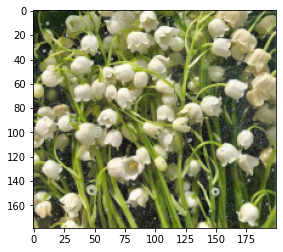

In [6]:
img_input = cv2.imread(im_path, cv2.IMREAD_COLOR)
img_input = cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB)

img_input = image_resize(img_input, width= 200)

plt.imshow(img_input)


Avendo estratto con Photoshop alcuni colori che mi sembravano rappresentativi dell'immagine, li genero creando delle celle di colore di dimensione dim_img
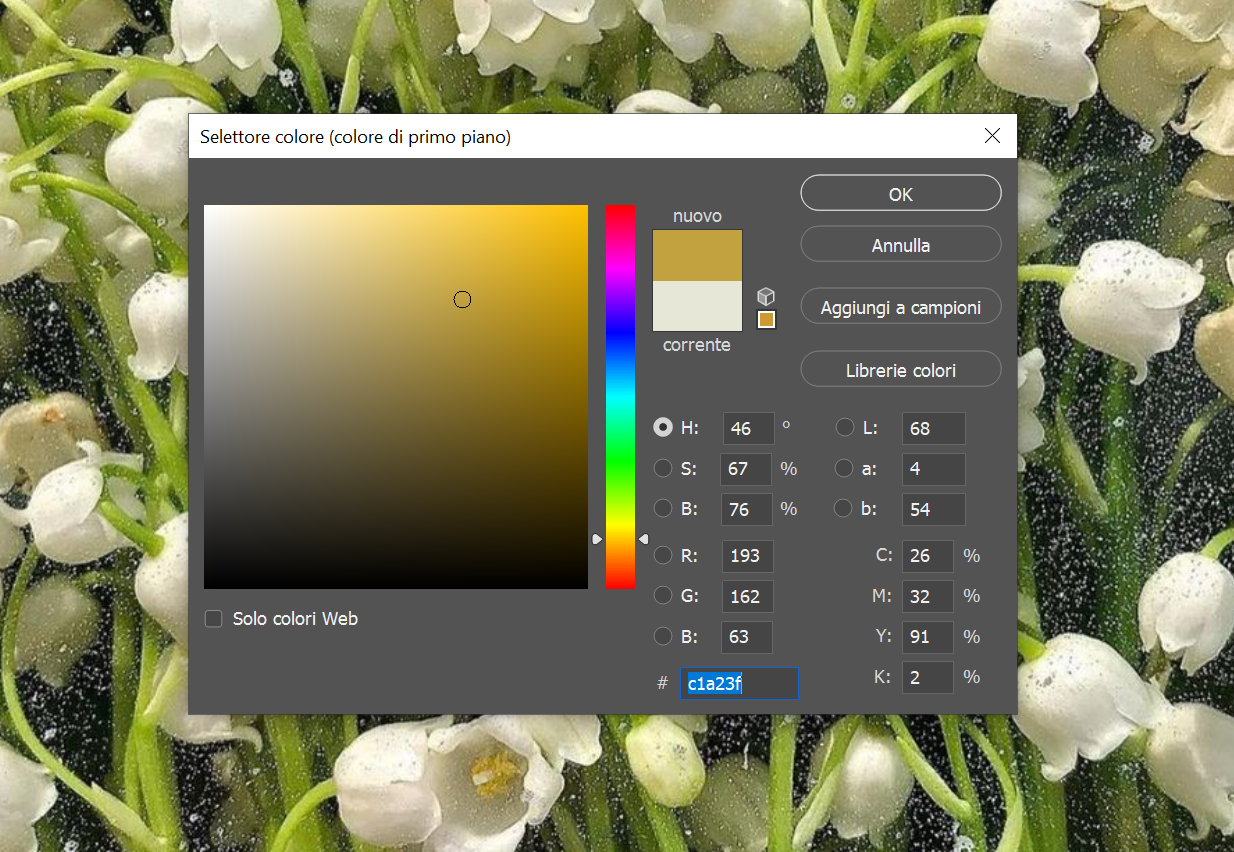

[array([230, 231, 215]), array([169, 188,  57]), array([16, 34,  8]), array([193, 162,  63])]


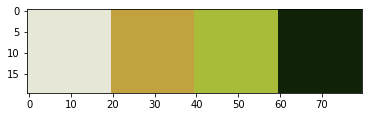

In [7]:
dim_img = 20

class RGB_Color:
  def __init__(self, R, G, B):
    self.R=R
    self.G=G
    self.B=B


def square_generator(color):
  color_square = np.ndarray((dim_img,dim_img,3), np.uint8)
  color_square[:,:,0] = color[0]
  color_square[:,:,1] = color[1]
  color_square[:,:,2] = color[2]
  return color_square

#SCELTA PALETTE (RGB)

BIANCO = np.array([230,231,215])
VERDE1 = np.array([169,188,57])
VERDE2 = np.array([16,34,8])
GIALLO = np.array([193,162,63])

palette = []
palette.append(BIANCO)
palette.append(VERDE1)
palette.append(VERDE2)
palette.append(GIALLO)

print(palette)

#GENERAZIONE SAMPLE

SAMPLE_BIANCO = square_generator(BIANCO)
SAMPLE_VERDE1 = square_generator(VERDE1)
SAMPLE_VERDE2 = square_generator(VERDE2)
SAMPLE_GIALLO = square_generator(GIALLO)

palette_show = cv2.hconcat([SAMPLE_BIANCO, SAMPLE_GIALLO, SAMPLE_VERDE1, SAMPLE_VERDE2])

#print(palette_show.shape)

plt.imshow(palette_show)
plt.show()


Adesso è il momento di stabilire una metrica per misurare la distanza tra due colori. Scelgo banalmente lo spazio RGB a 3 dimensioni e considero come coordinate del colore x1=R x2=G e x3=B e come distanza la norma euclidea.

Ricreo un'immagine delle stesse dimensioni dell'immagine di input e per ogni pixel inserisco il colore della palette che più si avvicina ad esso.

In [8]:
def color_distance(color1, color2):

  distance = (color1[0] - color2[0])**2 + (color1[1] - color2[1])**2 + (color1[2] - color2[2])**2
  return distance.astype(np.float32)


(179, 200, 3)
(179, 200, 3)


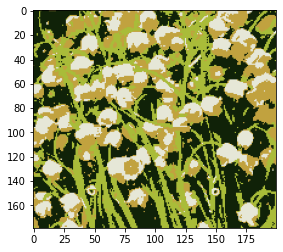

In [9]:
def palette_choose(palette, pixel):

  #Per ogni pixel slista la palette di colori e restituisce il colore più vicino (Quello con minima distanza pixel-colore)

  distances = []

  for index, color in enumerate(palette):
    distances.append(color_distance(pixel, color))
    #print(index, color)

  (minvalue,minIndex) = min((v,i) for i,v in enumerate(distances))

  return palette[minIndex]



#DEFINISCO L'IMMAGINE DI OUTPUT in base alla grandezza di quella di input
print(img_input.shape)
img_out = np.zeros_like(img_input)

print(img_out.shape)

### Finalmente posso iterare su tutta l'immagine di input attraverso il metodo palette_choose(palette, pixel)

for index_x, x in enumerate(img_input[:,0,0]):
  for index_y, y in enumerate(img_input[0,:,0]):
    choosen = palette_choose(palette, img_input[index_x, index_y, :])
    img_out[index_x, index_y] = [choosen[0], choosen[1], choosen[2]]

img_save = cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)
cv2.imwrite('data/output.png', img_save)

plt.imshow(img_out)
plt.show()



## PROVA
Provo ad applicare lo stesso procedimento ma con la distanza calcolata nello spazio di colore HSV

In [10]:
palette_HSV = []

BIANCO = np.uint8([[[230,231,215 ]]])
VERDE1 = np.uint8([[[169,188,57 ]]])
VERDE2 = np.uint8([[[16,34,8 ]]])
GIALLO = np.uint8([[[193,162,63 ]]])

print(BIANCO)


BIANCO = cv2.cvtColor(BIANCO, cv2.COLOR_RGB2HSV)
VERDE1 = cv2.cvtColor(VERDE1, cv2.COLOR_RGB2HSV)
VERDE2 = cv2.cvtColor(VERDE2, cv2.COLOR_RGB2HSV)
GIALLO = cv2.cvtColor(GIALLO, cv2.COLOR_RGB2HSV)

BIANCO = BIANCO[0][0]
VERDE1 = VERDE1[0][0]
VERDE2 = VERDE2[0][0]
GIALLO = GIALLO[0][0]

palette_HSV.append(BIANCO)
palette_HSV.append(VERDE1)
palette_HSV.append(VERDE2)
palette_HSV.append(GIALLO)

print(palette_HSV)

[[[230 231 215]]]
[array([ 32,  18, 231], dtype=uint8), array([ 34, 178, 188], dtype=uint8), array([ 51, 195,  34], dtype=uint8), array([ 23, 172, 193], dtype=uint8)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in ubyte_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


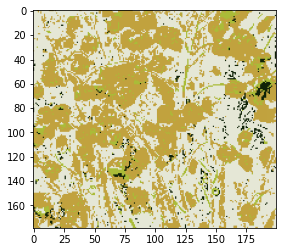

In [11]:
img_hsv = cv2.cvtColor(img_input, cv2.COLOR_RGB2HSV)

for index_x, x in enumerate(img_hsv[:,0,0]):
  for index_y, y in enumerate(img_hsv[0,:,0]):
    choosen = palette_choose(palette_HSV, img_hsv[index_x, index_y, :])
    img_out[index_x, index_y] = [choosen[0], choosen[1], choosen[2]]

#print(img_hsv[0])
img_out = cv2.cvtColor(img_out, cv2.COLOR_HSV2RGB)

#print(img_out[0])

img_save = cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)
cv2.imwrite('data/output_hsv.png', img_save)

plt.imshow(img_out)
plt.show()

Provo con HLS

In [12]:
palette_HLS = []

BIANCO = np.uint8([[[230,231,215 ]]])
VERDE1 = np.uint8([[[169,188,57 ]]])
VERDE2 = np.uint8([[[16,34,8 ]]])
GIALLO = np.uint8([[[193,162,63 ]]])


BIANCO = cv2.cvtColor(BIANCO, cv2.COLOR_RGB2HLS)
VERDE1 = cv2.cvtColor(VERDE1, cv2.COLOR_RGB2HLS)
VERDE2 = cv2.cvtColor(VERDE2, cv2.COLOR_RGB2HLS)
GIALLO = cv2.cvtColor(GIALLO, cv2.COLOR_RGB2HLS)

BIANCO = BIANCO[0][0]
VERDE1 = VERDE1[0][0]
VERDE2 = VERDE2[0][0]
GIALLO = GIALLO[0][0]

palette_HLS.append(BIANCO)
palette_HLS.append(VERDE1)
palette_HLS.append(VERDE2)
palette_HLS.append(GIALLO)

print(palette_HLS)

[array([ 32, 223,  64], dtype=uint8), array([ 34, 122, 136], dtype=uint8), array([ 51,  21, 158], dtype=uint8), array([ 23, 128, 131], dtype=uint8)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in ubyte_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


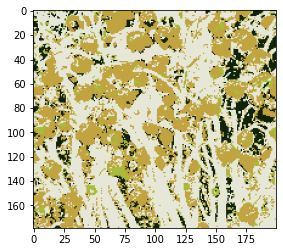

In [13]:
img_HLS = cv2.cvtColor(img_input, cv2.COLOR_RGB2HLS)

for index_x, x in enumerate(img_HLS[:,0,0]):
  for index_y, y in enumerate(img_HLS[0,:,0]):
    choosen = palette_choose(palette_HLS, img_HLS[index_x, index_y, :])
    img_out[index_x, index_y] = [choosen[0], choosen[1], choosen[2]]

img_save = cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)
cv2.imwrite('data/output_hls.png', img_save)

img_out = cv2.cvtColor(img_out, cv2.COLOR_HLS2RGB)

plt.imshow(img_out)
plt.show()

A quanto pare gli spazi di colore non mantengono invariata la metrica.